In [1]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
import tensorflow as tf
from tensorflow import keras
from numpy.random import randn
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from keras.layers import Embedding,Flatten,Dense,LSTM,Bidirectional
from keras.layers import SpatialDropout1D
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path = '/content/gdrive/My Drive/imdb_reviews/preprocessed_imdbTrain.tsv'
df = pd.read_csv(path,sep='\t')

In [5]:
df.head()

,Unnamed: 0,id,sentiment,review,normalized_reviews
0,0,5814_8,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...
1,1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",the classic war of the worlds by timothy hines...
2,2,7759_3,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager nicholas bell g...
3,3,3630_4,0,It must be assumed that those who praised this...,it must be assumed that those who praised this...
4,4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy and wondrously unpretentious 8...


In [6]:
df.review[1]

'\\The Classic War of the Worlds\\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells\' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \\"critics\\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \\"critics\\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells\' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \\"critics\\" perceive to be its shortcomings."'

In [7]:
df.normalized_reviews[1]

'the classic war of the worlds by timothy hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate h g wells classic book mr hines succeeds in doing so i and those who watched his film with me appreciated the fact that it was not the standard predictable hollywood fare that comes out every year e g the spielberg version with tom cruise that had only the slightest resemblance to the book obviously everyone looks for different things in a movie those who envision themselves as amateur critics look only to criticize everything they can others rate a movie on more important baseslike being entertained which is why most people never agree with the critics we enjoyed the effort mr hines put into being faithful to h g wells classic novel and we found it to be very entertaining this made it easy to overlook what the critics perceive to be its shortcomings '

In [8]:
sentences = df.normalized_reviews.to_list()
labels = df.sentiment.to_list()

In [9]:
# word_embed = Word2Vec(reviews,size=200,iter=10)

In [10]:
# from gensim.test.utils import get_tmpfile
# path = get_tmpfile("word2vec.model")
# word_embed.save("word2vec.model")

In [11]:
word_embed = Word2Vec.load('/content/gdrive/My Drive/imdb_reviews/word2vec.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [12]:
word_embed.most_similar(positive=['exciting'], topn = 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('interesting', 0.6973404884338379),
 ('thrilling', 0.6810983419418335),
 ('entertaining', 0.6787074208259583),
 ('enjoyable', 0.6772125959396362),
 ('innovative', 0.6724862456321716),
 ('suspenseful', 0.6717040538787842),
 ('imaginative', 0.670185387134552),
 ('intriguing', 0.6700772047042847),
 ('tense', 0.6655546426773071),
 ('effective', 0.6534300446510315)]

In [13]:
df.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [14]:
len(word_embed.wv.vocab)

30600

In [15]:
mid_len = np.median([len(sent.split()) for sent in sentences])
mid_len

172.0

In [16]:
maxlen = 170
max_words = 15000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=maxlen,padding='post',truncating='post')
labels = np.asarray(labels)

In [17]:
embedding_dim = 200
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
       if word in word_embed.wv.vocab:
          embedding_matrix[i] = word_embed.wv[word]
       else:
          embedding_matrix[i] = randn(200)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [19]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=23)

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
# setting learning rate
opt = Adam(learning_rate=0.0005)

# LSTM

In [21]:
# model1 = Sequential()
# model1.add(Embedding(max_words,200,input_length=maxlen))
# model1.layers[0].set_weights([embedding_matrix])
# model1.layers[0].trainable = True
# model1.add(LSTM(256,activation='tanh'))
# model1.add(Dense(1,activation='sigmoid'))
# model1.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [22]:
# model1.fit(x_train, y_train,batch_size=128,epochs=50,verbose=2,callbacks=[es],validation_data=(x_valid,y_valid))

In [23]:
# plt.figure(figsize=(7,7))
# plt.plot(model1.history.history['loss'])
# plt.plot(model1.history.history['val_loss'])
# plt.title('Single layer lstm loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [ ]:
# stacked lstm with dropout 

model2 = Sequential()
model2.add(Embedding(max_words,200,input_length=maxlen))
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = True
model2.add(LSTM(200,activation='tanh',recurrent_dropout=0.5,return_sequences=True))
model2.add(LSTM(100,activation='tanh',dropout=0.5,recurrent_dropout=0.5))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
model2.fit(x_train, y_train,batch_size=128,epochs=50,validation_data=(x_valid,y_valid),verbose=2,callbacks=[es])

Epoch 1/50
96/96 - 160s - loss: 0.6689 - accuracy: 0.5949 - val_loss: 0.7038 - val_accuracy: 0.5141
Epoch 2/50
96/96 - 156s - loss: 0.6257 - accuracy: 0.6520 - val_loss: 0.5632 - val_accuracy: 0.7446
Epoch 3/50
96/96 - 157s - loss: 0.5541 - accuracy: 0.7265 - val_loss: 0.4651 - val_accuracy: 0.7830
Epoch 4/50
96/96 - 155s - loss: 0.5263 - accuracy: 0.7538 - val_loss: 0.4668 - val_accuracy: 0.7918
Epoch 5/50
96/96 - 157s - loss: 0.4268 - accuracy: 0.8044 - val_loss: 0.4288 - val_accuracy: 0.8112
Epoch 6/50
96/96 - 155s - loss: 0.3924 - accuracy: 0.8384 - val_loss: 0.4135 - val_accuracy: 0.8309
Epoch 7/50
96/96 - 156s - loss: 0.3283 - accuracy: 0.8716 - val_loss: 0.3891 - val_accuracy: 0.8358
Epoch 8/50
96/96 - 155s - loss: 0.2941 - accuracy: 0.8850 - val_loss: 0.3738 - val_accuracy: 0.8432
Epoch 9/50
96/96 - 156s - loss: 0.2494 - accuracy: 0.9106 - val_loss: 0.3910 - val_accuracy: 0.8461
Epoch 10/50
96/96 - 154s - loss: 0.2142 - accuracy: 0.9256 - val_loss: 0.3897 - val_accuracy: 0.8497

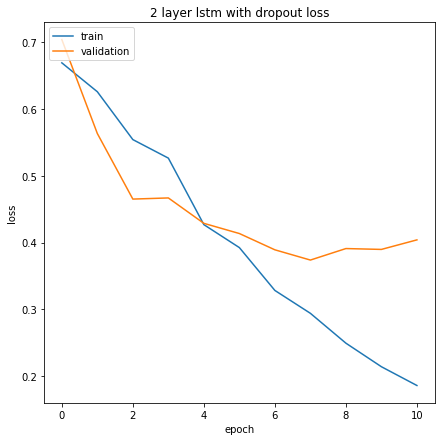

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(model2.history.history['loss'])
plt.plot(model2.history.history['val_loss'])
plt.title('2 layer lstm with dropout loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Bidirectional Lstm

model3 = Sequential()
model3.add(Embedding(max_words,200,input_length=maxlen))
model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = True
model3.add(Bidirectional(LSTM(180,recurrent_dropout=0.5)))
model3.add(Dense(1,activation='sigmoid'))
model3.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
model3.fit(x_train, y_train,batch_size=128,epochs=50,validation_data=(x_valid,y_valid),verbose=2,callbacks=[es])

Epoch 1/50
96/96 - 152s - loss: 0.5489 - accuracy: 0.7174 - val_loss: 0.4482 - val_accuracy: 0.8150
Epoch 2/50
96/96 - 149s - loss: 0.4235 - accuracy: 0.8106 - val_loss: 0.4184 - val_accuracy: 0.8154
Epoch 3/50
96/96 - 152s - loss: 0.3524 - accuracy: 0.8497 - val_loss: 0.3943 - val_accuracy: 0.8274
Epoch 4/50
96/96 - 149s - loss: 0.2973 - accuracy: 0.8797 - val_loss: 0.5305 - val_accuracy: 0.7792
Epoch 5/50
96/96 - 150s - loss: 0.2627 - accuracy: 0.8958 - val_loss: 0.3687 - val_accuracy: 0.8514
Epoch 6/50
96/96 - 149s - loss: 0.2088 - accuracy: 0.9218 - val_loss: 0.3676 - val_accuracy: 0.8539
Epoch 7/50
96/96 - 149s - loss: 0.1698 - accuracy: 0.9371 - val_loss: 0.3853 - val_accuracy: 0.8613
Epoch 8/50
96/96 - 148s - loss: 0.1434 - accuracy: 0.9513 - val_loss: 0.4021 - val_accuracy: 0.8530
Epoch 9/50
96/96 - 148s - loss: 0.0905 - accuracy: 0.9731 - val_loss: 0.4387 - val_accuracy: 0.8571
Epoch 00009: early stopping


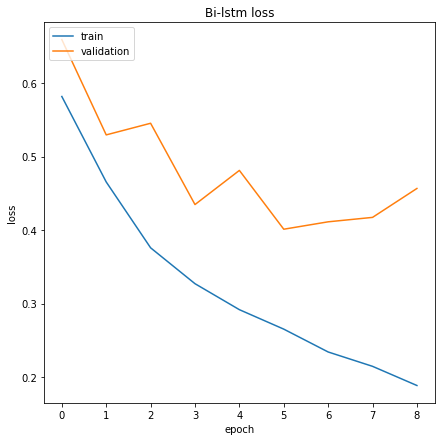

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(model3.history.history['loss'])
plt.plot(model3.history.history['val_loss'])
plt.title('Bi-lstm loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Lstm with attention

def build_model(embedding_matrix):
     print('Building model...')
    
     input_ = keras.layers.Input(shape=(maxlen,))

     x = keras.layers.Embedding(input_dim=max_words,output_dim=200,embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=True)(input_)
     
     x, x_h_state, _ = (keras.layers.LSTM(170, return_sequences=True, return_state=True))(x) 
     x_ctx = tf.keras.layers.AdditiveAttention()([x_h_state, x])
     #c_out = keras.layers.concatenate([x_ctx])

     output = keras.layers.Dense(1, activation='sigmoid')(x_ctx)

     model = keras.Model(inputs=[input_], outputs=[output])

     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss='binary_crossentropy', metrics=['accuracy'])
     
     return model

In [ ]:
ES  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [ ]:
model_attention = build_model(embedding_matrix)

model_attention.fit(x_train, y_train,batch_size=64,epochs=50,validation_data=(x_valid,y_valid),verbose=2,callbacks=[ES])

Building model...
Epoch 1/50
192/192 - 22s - loss: 0.4356 - accuracy: 0.7916 - val_loss: 0.3529 - val_accuracy: 0.8499
Epoch 2/50
192/192 - 22s - loss: 0.3140 - accuracy: 0.8696 - val_loss: 0.3299 - val_accuracy: 0.8601
Epoch 3/50
192/192 - 22s - loss: 0.2572 - accuracy: 0.8942 - val_loss: 0.3322 - val_accuracy: 0.8634
Epoch 4/50
192/192 - 22s - loss: 0.2039 - accuracy: 0.9203 - val_loss: 0.3373 - val_accuracy: 0.8666
Epoch 5/50
192/192 - 22s - loss: 0.1375 - accuracy: 0.9501 - val_loss: 0.3625 - val_accuracy: 0.8682
Epoch 00005: early stopping


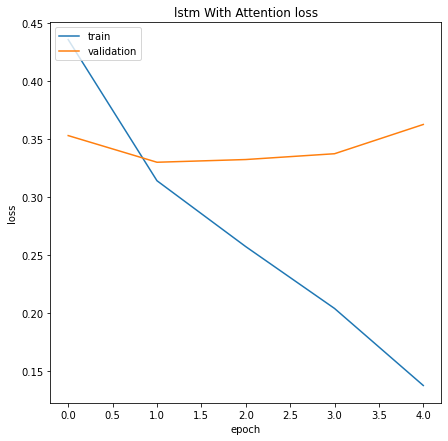

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(model_attention.history.history['loss'])
plt.plot(model_attention.history.history['val_loss'])
plt.title('lstm With Attention loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# model1.save('lstm_1layer.h5')
# model2.save('lstm_2layer.h5')
# model3.save('bi_lstm.h5')

##CNN

In [ ]:
 # CNN with 1 kernel size

# model4 = Sequential()
# model4.add(Embedding(max_words, 200, input_length=maxlen))
# model4.layers[0].set_weights([embedding_matrix])
# model4.layers[0].trainable = True
# model4.add(Conv1D(filters=128, kernel_size=2, activation='tanh'))
# model4.add(MaxPooling1D(pool_size=2))
# model4.add(Flatten())
# model4.add(Dense(10, activation='tanh'))
# model4.add(Dense(1, activation='sigmoid'))
# # compile network
# model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# model4.fit(x_train, y_train,batch_size=128,epochs=50,validation_data=(x_valid,y_valid),verbose=2,callbacks=[es])

In [ ]:
# plt.figure(figsize=(7,7))
# plt.plot(model4.history.history['loss'])
# plt.plot(model4.history.history['val_loss'])
# plt.title('CNN with 1 kernel loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [ ]:
 # CNN with 1 kernel & spatial dropout 

model5 = Sequential()
model5.add(Embedding(max_words, 200, input_length=maxlen))
model5.layers[0].set_weights([embedding_matrix])
model5.layers[0].trainable = True
model5.add(Conv1D(filters=256, kernel_size=3, activation='tanh'))
model5.add(SpatialDropout1D(0.5))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Flatten())
model5.add(Dense(10, activation='tanh'))
model5.add(Dense(1, activation='sigmoid'))
# compile network
model5.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model5.fit(x_train, y_train,batch_size=128,epochs=50,validation_data=(x_valid,y_valid),verbose=2,callbacks=[es])

Epoch 1/50
96/96 - 8s - loss: 0.6539 - accuracy: 0.6319 - val_loss: 0.5424 - val_accuracy: 0.7587
Epoch 2/50
96/96 - 7s - loss: 0.4829 - accuracy: 0.7847 - val_loss: 0.4446 - val_accuracy: 0.8055
Epoch 3/50
96/96 - 7s - loss: 0.3975 - accuracy: 0.8300 - val_loss: 0.4117 - val_accuracy: 0.8257
Epoch 4/50
96/96 - 7s - loss: 0.3405 - accuracy: 0.8639 - val_loss: 0.4048 - val_accuracy: 0.8272
Epoch 5/50
96/96 - 7s - loss: 0.2963 - accuracy: 0.8841 - val_loss: 0.3948 - val_accuracy: 0.8390
Epoch 6/50
96/96 - 7s - loss: 0.2519 - accuracy: 0.9058 - val_loss: 0.3871 - val_accuracy: 0.8390
Epoch 7/50
96/96 - 7s - loss: 0.2232 - accuracy: 0.9193 - val_loss: 0.4108 - val_accuracy: 0.8394
Epoch 8/50
96/96 - 7s - loss: 0.1872 - accuracy: 0.9348 - val_loss: 0.4064 - val_accuracy: 0.8429
Epoch 9/50
96/96 - 7s - loss: 0.1607 - accuracy: 0.9476 - val_loss: 0.4246 - val_accuracy: 0.8450
Epoch 00009: early stopping


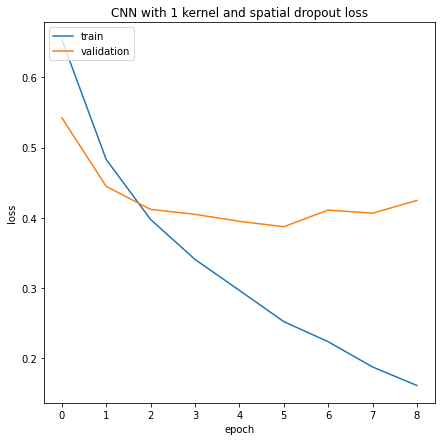

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(model5.history.history['loss'])
plt.plot(model5.history.history['val_loss'])
plt.title('CNN with 1 kernel and spatial dropout loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
 # CNN with multiple kernels & spatial dropout
def define_model():
    # channel 1
    inputs1 = Input(shape=(maxlen,))
    embedding1 = Embedding(max_words, 200,weights=([embedding_matrix]),trainable=True)(inputs1)
    conv1 = Conv1D(filters=128, kernel_size=1, activation='tanh')(embedding1)
    drop1 = SpatialDropout1D(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    
    embedding2 = Embedding(max_words, 200,weights=([embedding_matrix]),trainable=True)(inputs1)
    conv2 = Conv1D(filters=128, kernel_size=2, activation='tanh')(embedding2)
    drop2 = SpatialDropout1D(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    
    embedding3 = Embedding(max_words, 200,weights=([embedding_matrix]),trainable=True)(inputs1)
    conv3 = Conv1D(filters=128, kernel_size=3, activation='tanh')(embedding3)
    drop3 = SpatialDropout1D(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # FCs
    dense1 = Dense(10, activation='tanh')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [ ]:
model6 = define_model()
model6.fit(x_train, y_train,batch_size=128,epochs=50,validation_data=(x_valid,y_valid),verbose=2,callbacks=[es])

Epoch 1/50
96/96 - 19s - loss: 0.7556 - accuracy: 0.5012 - val_loss: 0.6916 - val_accuracy: 0.4964
Epoch 2/50
96/96 - 18s - loss: 0.6807 - accuracy: 0.5971 - val_loss: 0.6571 - val_accuracy: 0.6893
Epoch 3/50
96/96 - 17s - loss: 0.6205 - accuracy: 0.7157 - val_loss: 0.5441 - val_accuracy: 0.7886
Epoch 4/50
96/96 - 17s - loss: 0.4830 - accuracy: 0.8017 - val_loss: 0.4388 - val_accuracy: 0.8097
Epoch 5/50
96/96 - 18s - loss: 0.3935 - accuracy: 0.8323 - val_loss: 0.4179 - val_accuracy: 0.8196
Epoch 6/50
96/96 - 18s - loss: 0.3384 - accuracy: 0.8649 - val_loss: 0.3933 - val_accuracy: 0.8366
Epoch 7/50
96/96 - 18s - loss: 0.3032 - accuracy: 0.8808 - val_loss: 0.3883 - val_accuracy: 0.8402
Epoch 8/50
96/96 - 18s - loss: 0.2693 - accuracy: 0.8994 - val_loss: 0.3899 - val_accuracy: 0.8472
Epoch 9/50
96/96 - 17s - loss: 0.2453 - accuracy: 0.9116 - val_loss: 0.3831 - val_accuracy: 0.8490
Epoch 10/50
96/96 - 18s - loss: 0.2130 - accuracy: 0.9258 - val_loss: 0.3883 - val_accuracy: 0.8495
Epoch 11/

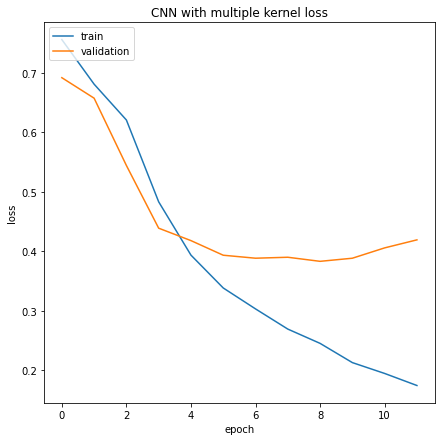

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(model6.history.history['loss'])
plt.plot(model6.history.history['val_loss'])
plt.title('CNN with multiple kernel loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
 # Stacked CNNs 

model7 = Sequential()
model7.add(Embedding(max_words, 200, input_length=maxlen))
model7.layers[0].set_weights([embedding_matrix])
model7.layers[0].trainable = True
model7.add(Conv1D(filters=256, kernel_size=3, activation='tanh'))
model7.add(Conv1D(filters=128, kernel_size=1, activation='tanh'))
model7.add(SpatialDropout1D(0.5))
model7.add(MaxPooling1D(pool_size=2))
model7.add(Flatten())
model7.add(Dense(10, activation='tanh'))
model7.add(Dense(1, activation='sigmoid'))
# compile network
model7.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model7.fit(x_train, y_train,batch_size=128,epochs=50,validation_data=(x_valid,y_valid),verbose=2,callbacks=[es])

Epoch 1/50
96/96 - 9s - loss: 0.6775 - accuracy: 0.5894 - val_loss: 0.5689 - val_accuracy: 0.7168
Epoch 2/50
96/96 - 8s - loss: 0.4780 - accuracy: 0.7845 - val_loss: 0.4285 - val_accuracy: 0.8200
Epoch 3/50
96/96 - 8s - loss: 0.3904 - accuracy: 0.8341 - val_loss: 0.4035 - val_accuracy: 0.8242
Epoch 4/50
96/96 - 8s - loss: 0.3485 - accuracy: 0.8552 - val_loss: 0.4409 - val_accuracy: 0.8141
Epoch 5/50
96/96 - 8s - loss: 0.2939 - accuracy: 0.8857 - val_loss: 0.3996 - val_accuracy: 0.8278
Epoch 6/50
96/96 - 8s - loss: 0.2421 - accuracy: 0.9083 - val_loss: 0.3936 - val_accuracy: 0.8421
Epoch 7/50
96/96 - 7s - loss: 0.2083 - accuracy: 0.9255 - val_loss: 0.4055 - val_accuracy: 0.8467
Epoch 8/50
96/96 - 8s - loss: 0.1773 - accuracy: 0.9371 - val_loss: 0.4312 - val_accuracy: 0.8436
Epoch 9/50
96/96 - 7s - loss: 0.1481 - accuracy: 0.9513 - val_loss: 0.4390 - val_accuracy: 0.8451
Epoch 00009: early stopping


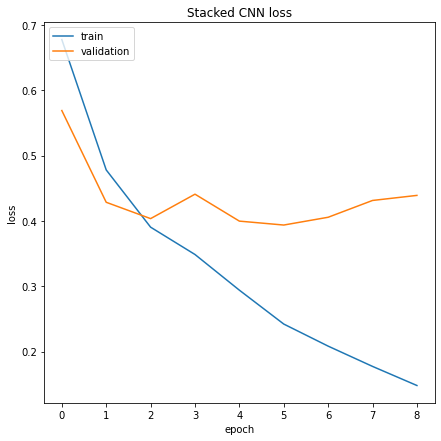

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(model7.history.history['loss'])
plt.plot(model7.history.history['val_loss'])
plt.title('Stacked CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# model6.save('multiCNN.h5')
# model7.save('stackedCNN.h5')

 # Diagnosing the Overfitting models

In [63]:
from keras.models import load_model
model_ = load_model('/content/gdrive/My Drive/lstm_2layer_pre.h5')

In [24]:
reviews = np.asarray(sentences)

In [25]:
rev_train, rev_test, lab_train, lab_test = train_test_split(reviews, labels, test_size=0.3, random_state=42)

In [26]:
r_train, r_valid, l_train, l_valid = train_test_split(rev_train, lab_train, test_size=0.3, random_state=23)

In [64]:
prob = model_.predict(x_valid)

In [28]:
# def perc_to_label(arr):
#     flag = []
#     for perc in arr:
#         percent_pos = perc[0]
#         if round(percent_pos,) == 0:
#            flag.append(0)
#         else:
#            flag.append(1)

#     return flag    

In [65]:
prob = [x[0] for x in prob]
prob = pd.Series(prob)

In [66]:
prob

0       0.840385
1       0.019486
2       0.987940
3       0.984841
4       0.011456
          ...   
5245    0.946063
5246    0.995460
5247    0.798003
5248    0.955879
5249    0.773519
Length: 5250, dtype: float64

In [31]:
# lstm_2layer_y = perc_to_label(out)

In [32]:
# out1 = model3.predict(x_valid)
# out2 = model6.predict(x_valid)
# out3 = model7.predict(x_valid)

In [33]:
# bilstm_y = perc_to_label(out1)

In [34]:
# multicnn_y = perc_to_label(out2)
# stackedcnn_y = perc_to_label(out3)

In [35]:
# prediction = {'reviews':r_valid,'true_label':l_valid,'lstm_2layer':lstm_2layer_y,'bi_lstm':bilstm_y,'multicnn':multicnn_y,'stackedcnn':stackedcnn_y}

# pred_df = pd.DataFrame(prediction,columns=['reviews','true_label','lstm_2layer','bi_lstm','multicnn','stackedcnn'])

In [36]:
# pred_df.shape

In [37]:
# pred_df.head()

In [38]:
# pred_df.to_csv('model_prediction.csv',index=False,header=True)

In [39]:
pred_df = pd.read_csv('/content/gdrive/My Drive/imdb_reviews/model_prediction.csv')
pred_df.head()

,reviews,true_label,lstm_2layer,bi_lstm,multicnn,stackedcnn
0,a lot has been said about shinjuku triad socie...,1,1,1,1,1
1,a very silly movie this starts with a soft por...,1,1,0,0,0
2,movies like this one and c r a z y make me ve...,1,1,1,1,1
3,greetings again from the darkness stunning pho...,1,1,1,1,1
4,where to start i feel violated thats right vi...,0,0,0,0,0


In [40]:
diagnose_df = pred_df.sample(n=10,random_state=34)
diagnose_df.reset_index(inplace=True,drop=True)
diagnose_df.head(10)

,reviews,true_label,lstm_2layer,bi_lstm,multicnn,stackedcnn
0,dreamgirls despite its fistful of tony wins in...,0,1,1,1,1
1,the poverty row horror pictures of the 1930s a...,0,0,0,0,0
2,amazing movie that in theory should be boring ...,1,1,1,1,1
3,i have to admit i did not finish this movie be...,0,0,0,0,0
4,i saw this film at its premier at sundance 09 ...,0,0,1,0,1
5,in my opinion the best movie ever i love when ...,1,1,1,1,1
6,playwright sidney bruhl a wonderfully overthet...,1,1,1,1,1
7,a great story based on a true story about a yo...,1,1,1,1,1
8,i love this film the noir imagery combined wit...,1,1,1,1,1
9,ive seen this about 2 or 3 times and havent re...,1,1,1,1,1


In [41]:
diagnose_df.iloc[0,0]

'dreamgirls despite its fistful of tony wins in an incredibly weak year on broadway has never been what one would call a jewel in the crown of stage musicals however that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile onscreen unfortunately what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact first the score has never been one of the strong points of this production and the film does not change that factor there are lots of songs perhaps too many but few of them are especially memorable the closest any come to catchy tunes are the title song and one night only  the much acclaimed and i am telling you that i am not going is less a great song than it is a dramatic set piece for the character of effie jennifer hudson the film is slick and technically wellproduced but the story and characters are surprisingly thin and lacking in any resonance the

  The above review is mixed

In [42]:
diagnose_df.iloc[4,0]

'i saw this film at its premier at sundance 09 since american beauty is a movie that had something to say i had hopes for towelhead unfortunately it was a disappointment in fact of countless movies ive seen in almost a dozen sundance festivals towelhead is the only sundance movie ive ever wanted to walk out early from the worst problem with towelhead is that it so obviously originates with a collection of provocative concepts concerning cultural stereotypes rather than with an organic human drama the screenplay derives from the novel of the same name by alicia erian the famous edith wharton quote comes to mind i have never known a novel that was good enough to be good in spite of its being adapted to the authors political views that observation is especially devastating for towelhead because its political views are so stale and simplistic if there ever was a time when towelheads white male villains condescending portrayals of blacks ironic treatments of foreign cultures etc  were fresh

 The above review is poor

In [43]:
pos_df = pred_df[pred_df.true_label == 1].sample(n=10,random_state=27)
pos_df.reset_index(inplace=True,drop=True)
pos_df.head(10)

,reviews,true_label,lstm_2layer,bi_lstm,multicnn,stackedcnn
0,cosimo luis guzman ends up in prison for car b...,1,1,1,1,0
1,got to this show late believe it was the 3rd ...,1,1,1,1,1
2,fascinating movie based on a true story about ...,1,1,1,1,1
3,the film really challenges your notions of ide...,1,1,1,1,1
4,this movie documents a transformative experien...,1,1,1,1,1
5,there wasnt a dry eye amongst the audience yes...,1,1,1,1,1
6,roman polanski plays trelkovsky who rents an a...,1,1,1,1,1
7,good action show but nothing new this one took...,1,0,0,0,0
8,in the ten years since wildside aired nothing ...,1,1,1,1,1
9,a great suspense movie with terrific slow came...,1,1,1,1,1


In [44]:
pos_df.iloc[7,0]

'good action show but nothing new this one took place high in the mountains which showed some nice scenery and such one man takes on a group of mercenaries the lead flies and he kicks butt it could have been called rambo goes to the rockies it was that pat it did have one very effective scene right at the first of the film which had me cringing in horror not a bad picture but just same ol same ol '

This is a mixed review

In [45]:
pos_df.iloc[2,0]

'fascinating movie based on a true story about an australian woman lindy chamberlain meryl streep accused of killing her baby daughter she insists that a dingo took her baby but the story is highly suspicious the film is actually about the media circus that took place around the case the way australians interpreted what was presented in the media and the lynch mob mentality that ultimately led to the womans conviction based on barely any hard evidence i love films that question the media and also films that take a hard look on how people are railroaded by the justice system ive always thought that juries ought to be showed 12 angry men before they go through with their duties its not as has often been said a liberal movie but a clinical look at how we as human beings interpret events based so much on our prejudices and a desire for revenge a cry in the dark is likewise clinical schepisi is careful not to make the film at all melodramatic some may find the film boring or dry but i found

This is a positive review

In [46]:
good_bucket = pred_df.loc[((pred_df.true_label == 1)&(pred_df.lstm_2layer == 1)&(pred_df.bi_lstm == 1)&(pred_df.multicnn == 1)&(pred_df.stackedcnn == 1))|((pred_df.true_label == 0)&(pred_df.lstm_2layer == 0)&(pred_df.bi_lstm == 0)&(pred_df.multicnn == 0)&(pred_df.stackedcnn == 0))]
good_bucket.sample(n=30,random_state=18)

,reviews,true_label,lstm_2layer,bi_lstm,multicnn,stackedcnn
2395,i kind of consider myself as the 1 fan of hidd...,1,1,1,1,1
4063,daniella has some issues brewing under her att...,0,0,0,0,0
993,this is a rather dull movie about a scientist ...,0,0,0,0,0
1831,this film is a lyrical and romantic memoir tol...,1,1,1,1,1
150,this could be well have been the definitive fi...,1,1,1,1,1
3779,elfriede jelinek not quite a household name ye...,0,0,0,0,0
452,everyone plays their part pretty well in this ...,1,1,1,1,1
3349,a tragically wonderful movie brings us to a ja...,1,1,1,1,1
2607,strange how less than 2 hours can seem like a ...,0,0,0,0,0
3475,paul hennessy and his wife cate must deal with...,1,1,1,1,1


In [47]:
bad_bucket = pred_df.loc[((pred_df.true_label == 1)&(pred_df.lstm_2layer == 0)&(pred_df.bi_lstm == 0)&(pred_df.multicnn == 0)&(pred_df.stackedcnn == 0))|((pred_df.true_label == 0)&(pred_df.lstm_2layer == 1)&(pred_df.bi_lstm == 1)&(pred_df.multicnn == 1)&(pred_df.stackedcnn == 1))]
bad_bucket.sample(n=30,random_state=19)

,reviews,true_label,lstm_2layer,bi_lstm,multicnn,stackedcnn
1657,when i first saw this film in cinema 11 years ...,0,1,1,1,1
1680,this move is about as bad as they come i was h...,0,1,1,1,1
1989,very good except for the ending which was a hu...,1,0,0,0,0
3913,horror is perhaps one of two genres where logi...,1,0,0,0,0
3810,warning tons of dead giveaways dont read if yo...,1,0,0,0,0
2171,this film was the recipient of the 1990 academ...,0,1,1,1,1
3907,i was really surprised with this movie going i...,1,0,0,0,0
1882,the endless bounds of our inhumanity to our ow...,1,0,0,0,0
49,it definitely fits the time period as the axis...,0,1,1,1,1
2262,this isnt the best bigfoot ever made but by th...,1,0,0,0,0


In [48]:
df1 = good_bucket.sample(n=30,random_state=18)
df2 = bad_bucket.sample(n=30,random_state=19)
idx1 = df1.index
idx2 = df2.index

In [49]:
print(type(idx1))
print(idx1)

<class 'pandas.core.indexes.numeric.Int64Index'>
Int64Index([2395, 4063,  993, 1831,  150, 3779,  452, 3349, 2607, 3475, 2510,
             657, 3305, 5025, 3625, 5174, 2732, 1906, 1278, 5170, 2665, 2250,
            5068,  933, 3218,  175,  627, 1026, 3644, 4140],
           dtype='int64')


In [50]:
idx = list(idx1) + list(idx2)

In [67]:
proba = prob.iloc[idx]

In [68]:
proba.shape

(60,)

In [69]:
proba.reset_index(inplace=True,drop=True)

In [54]:
# df3 = pd.concat([df1,df2])
# df3.to_excel('label_reannotate.xlsx',index=False,header=True)

In [70]:
human_label = pd.read_excel('/content/gdrive/My Drive/label_reannotate.xlsx')
human_label['prob_lstm'] = proba
human_label.head()

,reviews,true_label,lstm_2layer,bi_lstm,multicnn,stackedcnn,human,prob_lstm
0,i kind of consider myself as the 1 fan of hidd...,1,1,1,1,1,1,0.957998
1,daniella has some issues brewing under her att...,0,0,0,0,0,0,0.889915
2,this is a rather dull movie about a scientist ...,0,0,0,0,0,0,0.630198
3,this film is a lyrical and romantic memoir tol...,1,1,1,1,1,1,0.992207
4,this could be well have been the definitive fi...,1,1,1,1,1,-1,0.993655


In [71]:
gold_lab = human_label.loc[~(human_label[' human '] == -1)]
gold_lab.shape

(39, 8)

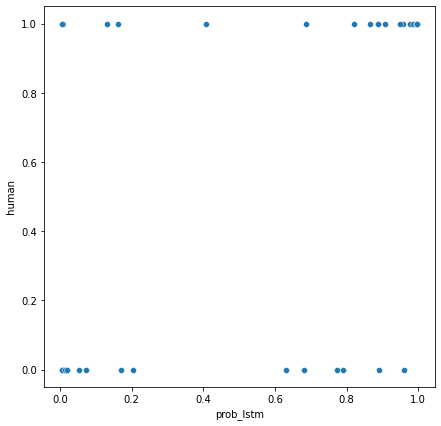

In [72]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=gold_lab,x='prob_lstm',y=' human ')

In [73]:
from scipy.stats import pearsonr

data1 = list(gold_lab[' human '])
data2 = list(gold_lab['prob_lstm'])
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.535
